#Submission 2   Belajar Pengembangan Machine Learning
Nama : Sukma Ramadhan. A



Import libraries yang akan digunakan

In [422]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime


In [423]:
df = pd.read_csv('/content/Energy.csv')
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [424]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


In [425]:
print(len(df))

70368


In [426]:
df.isnull().sum()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64

Drop Sebagian data

In [427]:
df = df.drop(columns=['NOTES','COST','END TIME','TYPE','UNITS'])

In [428]:
df.shape

(70368, 3)

In [429]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        70368 non-null  object 
 1   START TIME  70368 non-null  object 
 2   USAGE       70368 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [430]:
df = df.sort_values(by=['DATE'], axis=0, ascending=True)

In [431]:
df.head()

,DATE,START TIME,USAGE
6862,1/1/2017,10:30,0.56
6845,1/1/2017,6:15,0.34
6846,1/1/2017,6:30,0.34
6847,1/1/2017,6:45,0.34
6848,1/1/2017,7:00,0.33


Text(0.5, 1.0, 'Energy Usage')

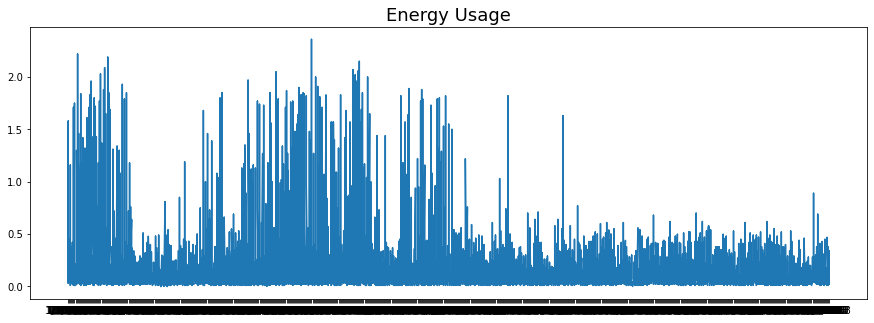

In [432]:
Dates = df['DATE'].values
Usage = df['USAGE'].values

plt.figure(figsize=(15,5))
plt.plot(Dates, Usage)
plt.title('Energy Usage', fontsize=18)

In [433]:
Dates_train, Dates_test, Usage_train, Usage_test = train_test_split(Dates, Usage, test_size=0.2, train_size=0.8, shuffle=False)

In [434]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [435]:
val_set = windowed_dataset(Usage, window_size=60, batch_size=100, shuffle_buffer=1000)


model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4),
])

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [436]:
Mae = (df['USAGE'].max() - df['USAGE'].min())* 0.1
print(Mae)

0.236


In [437]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
     if(logs.get('mae') < 0.1 and logs.get('val_mae') < 0.1):
      print('\n mae < 10%')
      self.model.stop_training = True
callbacks = myCallback()

In [438]:
hist = model.fit(val_set,
                 validation_data= val_set,
                 epochs=100,
                 verbose=2,
                 batch_size=64,
                 callbacks=[callbacks])

Epoch 1/100
704/704 - 105s - loss: 0.0251 - mae: 0.1045 - val_loss: 0.0237 - val_mae: 0.0972
Epoch 2/100
704/704 - 101s - loss: 0.0231 - mae: 0.0969 - val_loss: 0.0223 - val_mae: 0.0945

 mae < 10%
